In [ ]:
%pip install -q numpy matplotlib bitstruct

In [2]:
import numpy as np
import functools
import bitstruct.c as bs

In [3]:
def r32m(f: float):
    f = np.float32(f)
    fbytes = f.tobytes()
    fbytes = reversed(fbytes) # x86 is little endian
    fbits = functools.reduce(lambda a, b: a + b, (bin(b)[2:].rjust(8, '0') for b in fbytes))

    sign_bit = fbits[0]
    exp_bits = fbits[1:9]
    exp_val  = int(exp_bits, 2) - 127
    mant_bits = fbits[9:]

    norm_int = 1 if exp_val > -127 else 0

    return f"S:{sign_bit} E:{exp_bits}={exp_val:+04} M:[{norm_int}].{mant_bits} = {f}"


def r32bs(f: float):
    f = np.float32(f)
    fbytes = bytes(reversed(f.tobytes())) # x86 is little endian
    sign_bit, exp_int, mant_int = bs.unpack('u1u8u23', fbytes) # bit format line!
    exp_val = exp_int - 127
    norm_int = 1 if exp_val > -127 else 0   
    return f"S:{sign_bit} E:{bin(exp_int)[2:].rjust(8, '0')}={exp_val:+04} M:[{norm_int}].{bin(mant_int)[2:].rjust(23, '0')} = {f}"

r32=r32bs

print("Normalized")
print(r32(1.0))
print(r32(-1.0))
print(r32(2.5))
print(r32(-3.5))

print("Denormalized")
print(r32(0.0))
print(r32(-0.0))
print(r32(1.5 * 2**-126))
print(r32(1.5 * 2**-127))
print(r32(1.5 * 2**-128))

print("Specials")
print(r32(np.NaN))
print(r32(-np.NaN))
print(r32(np.inf))
print(r32(-np.inf))

Normalized
S:0 E:01111111=+000 M:[1].00000000000000000000000 = 1.0
S:1 E:01111111=+000 M:[1].00000000000000000000000 = -1.0
S:0 E:10000000=+001 M:[1].01000000000000000000000 = 2.5
S:1 E:10000000=+001 M:[1].11000000000000000000000 = -3.5
Denormalized
S:0 E:00000000=-127 M:[0].00000000000000000000000 = 0.0
S:1 E:00000000=-127 M:[0].00000000000000000000000 = -0.0
S:0 E:00000001=-126 M:[1].10000000000000000000000 = 1.7632415262334313e-38
S:0 E:00000000=-127 M:[0].11000000000000000000000 = 8.816207631167156e-39
S:0 E:00000000=-127 M:[0].01100000000000000000000 = 4.408103815583578e-39
Specials
S:0 E:11111111=+128 M:[1].10000000000000000000000 = nan
S:1 E:11111111=+128 M:[1].10000000000000000000000 = nan
S:0 E:11111111=+128 M:[1].00000000000000000000000 = inf
S:1 E:11111111=+128 M:[1].00000000000000000000000 = -inf


In [4]:
all_f16s = set()
def gen_f16s():
    for b0 in range(255):
        for b1 in range(255):
            try:
                f = np.frombuffer(bytes([b0, b1]), dtype=np.float16)[0]
                if not np.isnan(f):
                    all_f16s.add(f)
            except Exception as e:
                print(e)

gen_f16s()
print(f"Generated {len(all_f16s)} float16's.")

Generated 63241 float16's.


In [5]:
print("Floats:",
      min(all_f16s),
      max(all_f16s),
      min([f for f in all_f16s if f > 0.0]),
      max([f for f in all_f16s if not np.isinf(f)]))

Floats: -inf inf 6e-08 65470.0


Floats 1..16


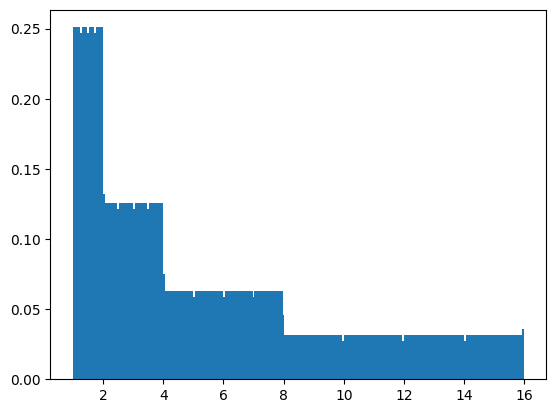

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
num_bins = 256

print("Floats 1..16")
plt.hist([f for f in all_f16s if 1 <= f < 16], num_bins,
         density=True,
         histtype='bar'
)

plt.show()